# Header

In [50]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math as math
import janitor
from sklearn.tree import DecisionTreeClassifier
import os

exec(open("../header.py").read())

Header initialized


# Import

In [51]:
threshold = 40

In [52]:
raw_train_data = pd.read_csv(processed_root("03-bag-of-words/threshold-"+str(threshold)+"/bow_train_data.csv"))
raw_val_data = pd.read_csv(processed_root("03-bag-of-words/threshold-"+str(threshold)+"/bow_val_data.csv"))
raw_test_data = pd.read_csv(processed_root("03-bag-of-words/threshold-"+str(threshold)+"/bow_test_data.csv"))

In [53]:
X_train = raw_train_data\
    .drop(['poetry_text', 'poetry_author'], axis = 1)
X_val = raw_val_data\
    .drop(['poetry_text', 'poetry_author'], axis = 1)
y_train = raw_train_data['poetry_author']
y_val = raw_val_data['poetry_author']

In [54]:
len(X_train.columns)

1897

# Model

In [58]:
dt = DecisionTreeClassifier(max_depth = 10, class_weight = "balanced")

# Train

In [59]:
dt.fit(X_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight='balanced', criterion='gini',
                       max_depth=10, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

# Evaluate

In [69]:
# Training
y_pred_train = dt.predict(X_train)
train_accuracy = np.mean(y_pred_train == y_train) * 100
print("Training Accuracy: %.2f%%"%(train_accuracy))

# Validation
y_pred_val = dt.predict(X_val)
val_accuracy = np.mean(y_pred_val == y_val) * 100
print("Validation Accuracy: %.2f%%"%(val_accuracy))

Training Accuracy: 58.64%
Validation Accuracy: 29.13%


In [77]:
def author_weighted_accuracy(pred, true):
    author_weighted_accuracy = pd.DataFrame({'true':true,
                                             'pred':pred})\
        .assign(correct = lambda x:x.true == x.pred)\
        .groupby('true')\
        .agg({'correct':'mean'})['correct']\
        .mean()
    
    return author_weighted_accuracy

In [78]:
author_weighted_accuracy(pred = y_pred_val, true = y_val)

0.31420109710550886

# Tune

In [85]:
def tuning_loop(max_depth_choices):
    
    train_accuracies = []
    val_accuracies = []
    author_val_accuracies = []

    for max_depth in max_depth_choices:
        dt = DecisionTreeClassifier(max_depth = max_depth, class_weight = "balanced")
        dt.fit(X_train, y_train)
        # Training
        y_pred_train = dt.predict(X_train)
        train_accuracy = np.mean(y_pred_train == y_train) * 100
        train_accuracies.append(train_accuracy)

        # Validation
        y_pred_val = dt.predict(X_val)
        val_accuracy = np.mean(y_pred_val == y_val) * 100
        val_accuracies.append(val_accuracy)
        
        # Author weighted validation
        author_val_accuracy = author_weighted_accuracy(pred = y_pred_val, true = y_val) * 100
        author_val_accuracies.append(author_val_accuracy)
        
    return train_accuracies, val_accuracies, author_val_accuracies

In [86]:
def plot_results(md, train, val, author_val):
    fig, ax = plt.subplots()
    ax.plot(md, train, label = "Train")
    ax.plot(md, val, label = "Validation")
    ax.plot(md, author_val, label = "Author-Weighted Validation")
    ax.set_title("Decision Tree Accuracy versus Max Depth")
    ax.set_xlabel("Max Depth")
    ax.set_ylabel("Accuracy (%)")
    ax.legend()
    
    print("Maximum validation accuracy, %.2f%% found at max depth of %d."\
      %(max(val), md[np.argmax(val)]))
    print("Maximum author weighted validation accuracy, %.2f%% found at max depth of %d."\
      %(max(author_val), md[np.argmax(author_val)]))

In [87]:
max_depth_choices = [(i+1)*5 for i in range(30)]
train_accuracies, val_accuracies, author_val_accuracies = tuning_loop(max_depth_choices)

Maximum validation accuracy, 33.07% found at max depth of 35.
Maximum author weighted validation accuracy, 35.10% found at max depth of 40.


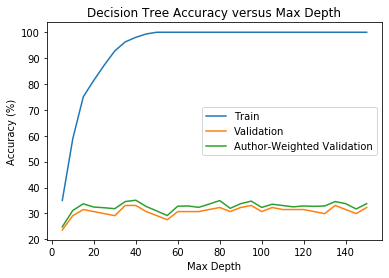

In [88]:
plot_results(max_depth_choices, train_accuracies, val_accuracies, author_val_accuracies)